In [1177]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, auc, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [1178]:
#data = pd.read_csv('../ult_sign_scrape/race_master/master_database.csv')
fe4 = pd.read_csv('../ult_sign_scrape/race_master/master_database_fe4.csv')
athletes = pd.read_csv('../ult_sign_scrape/athlete_dataframe/concat')
races = pd.read_csv('../ult_sign_scrape/race_master/master_list.csv')

In [1179]:
#clean = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
fe4_clean = fe4.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
fe4 = fe4_clean.dropna()

In [1180]:
fe4.corr()

,age,participant_id,runner_rank,status,race_id,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races
age,1.000000,-0.270411,-0.216783,0.075115,-0.010206,0.047769,0.018868,-0.043341,0.043721,-0.016771,-0.007417,0.000602,0.011360
participant_id,-0.270411,1.000000,-0.194335,-0.001664,0.386143,-0.020922,0.029178,-0.089945,-0.122077,-0.070901,-0.005315,-0.005174,-0.015240
runner_rank,-0.216783,-0.194335,1.000000,-0.190380,0.020117,-0.074137,-0.018915,0.115371,-0.045335,0.113499,-0.003333,-0.008166,0.007546
status,0.075115,-0.001664,-0.190380,1.000000,0.032448,0.079697,-0.038195,-0.150429,-0.094013,-0.118026,0.007557,0.009809,-0.000989
race_id,-0.010206,0.386143,0.020117,0.032448,1.000000,-0.058049,0.130348,-0.123373,-0.212501,0.017266,-0.015521,-0.024019,-0.029799
Season,0.047769,-0.020922,-0.074137,0.079697,-0.058049,1.000000,-0.229057,-0.543905,-0.242692,-0.293994,-0.004094,-0.006021,0.019240
Metro_area,0.018868,0.029178,-0.018915,-0.038195,0.130348,-0.229057,1.000000,-0.292363,0.117692,0.406314,-0.010899,-0.017804,-0.007776
WL_SO,-0.043341,-0.089945,0.115371,-0.150429,-0.123373,-0.543905,-0.292363,1.000000,0.413294,0.319025,0.028082,0.026839,0.006227
Entry_fee,0.043721,-0.122077,-0.045335,-0.094013,-0.212501,-0.242692,0.117692,0.413294,1.000000,0.334784,0.001548,-0.006640,-0.006176
PPM,-0.016771,-0.070901,0.113499,-0.118026,0.017266,-0.293994,0.406314,0.319025,0.334784,1.000000,0.003491,-0.017046,0.017571


Interesting observation - Very little spread between 25-75% in age of entrants (35-49). Max is 79 and min is ~12 (some cleaning of 0/1 ages may be necessary). 39-44 is the most common ages with nearly 400 in each category. Mid-life crisis???


Interesting observation - Appears that runner rank and age have the strongest relationships to the status column. Gender rank and age rank are similar in their relationship. Total races appears to have the weakest relationship for these features.

In [1181]:
gender_dummies_fe = pd.get_dummies(fe4.gender, prefix='gender')
#state_dummies = pd.get_dummies(fe2_clean.state, prefix='Home_State')
fe4 = fe4.join(gender_dummies_fe)
#fe4_clean = fe4_clean.join(state_dummies)

In [1182]:
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
 

print 'Before Coding:'
print pd.value_counts(fe4["status"])
fe4["status_coded"] = coding(fe4["status"], {'1':1,'2':1, '3':0})
print '\nAfter Coding:'
print pd.value_counts(fe4["status_coded"])
fe4 = fe4.drop(['status'], axis=1)
fe4.head()

Before Coding:
1    6291
2    3930
3     540
Name: status, dtype: int64

After Coding:
1    10221
0      540
Name: status_coded, dtype: int64


,age,gender,participant_id,runner_rank,race_id,race_name,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,gender_F,gender_M,status_coded
0,26,M,7148,88.39,11470,Bear,3,0,1,1,2.5,0.7174,0.6806,23.0,0.0,1.0,1
1,33,M,221721,90.00,11470,Bear,3,0,1,1,2.5,0.8132,0.6987,9.0,0.0,1.0,1
2,43,M,20020,83.63,11470,Bear,3,0,1,1,2.5,0.8272,0.7145,17.0,0.0,1.0,1
3,36,M,25441,73.22,11470,Bear,3,0,1,1,2.5,0.8995,0.8957,18.0,0.0,1.0,1
4,33,M,22562,87.77,11470,Bear,3,0,1,1,2.5,0.6807,0.6522,8.0,0.0,1.0,1


In [1183]:
fe4.corr()

,age,participant_id,runner_rank,race_id,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,gender_F,gender_M,status_coded
age,1.000000,-0.270411,-0.216783,-0.010206,0.047769,0.018868,-0.043341,0.043721,-0.016771,-0.007417,0.000602,0.011360,-0.050618,0.050618,0.011733
participant_id,-0.270411,1.000000,-0.194335,0.386143,-0.020922,0.029178,-0.089945,-0.122077,-0.070901,-0.005315,-0.005174,-0.015240,-0.026327,0.026327,-0.019896
runner_rank,-0.216783,-0.194335,1.000000,0.020117,-0.074137,-0.018915,0.115371,-0.045335,0.113499,-0.003333,-0.008166,0.007546,0.197594,-0.197594,0.002527
race_id,-0.010206,0.386143,0.020117,1.000000,-0.058049,0.130348,-0.123373,-0.212501,0.017266,-0.015521,-0.024019,-0.029799,-0.021824,0.021824,-0.081115
Season,0.047769,-0.020922,-0.074137,-0.058049,1.000000,-0.229057,-0.543905,-0.242692,-0.293994,-0.004094,-0.006021,0.019240,0.011332,-0.011332,-0.035099
Metro_area,0.018868,0.029178,-0.018915,0.130348,-0.229057,1.000000,-0.292363,0.117692,0.406314,-0.010899,-0.017804,-0.007776,0.072808,-0.072808,0.063267
WL_SO,-0.043341,-0.089945,0.115371,-0.123373,-0.543905,-0.292363,1.000000,0.413294,0.319025,0.028082,0.026839,0.006227,-0.052848,0.052848,0.053033
Entry_fee,0.043721,-0.122077,-0.045335,-0.212501,-0.242692,0.117692,0.413294,1.000000,0.334784,0.001548,-0.006640,-0.006176,0.036295,-0.036295,0.150438
PPM,-0.016771,-0.070901,0.113499,0.017266,-0.293994,0.406314,0.319025,0.334784,1.000000,0.003491,-0.017046,0.017571,0.000985,-0.000985,0.066751
Age_Rank,-0.007417,-0.005315,-0.003333,-0.015521,-0.004094,-0.010899,0.028082,0.001548,0.003491,1.000000,0.766592,0.177129,0.000289,-0.000289,0.007534


Once adding gender dummies, it appears that gender in and of itself may not be a great predictor of race status. Appears to be ~75% male and 25% female particitation in these races.

In [1184]:
y = fe4.pop('status_coded')
clean = fe4.drop(['gender', 'participant_id', 'race_name', 'race_id', 'Age_Rank', 'Gender_Rank', 'Total_races'\
                 , 'gender_M'], axis=1)
X = clean

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

In [1185]:
model = LR(C=100)
model.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [1186]:
predicted = model.predict_proba(X_test)

In [1187]:
log_loss(y_test, predicted)

0.20506065648496094

In [1188]:
model.coef_

array([[ -2.60655838e-04,  -1.53956285e-03,   7.57770170e-02,
          4.64655688e-01,   2.70842412e-02,   1.61221998e+00,
         -7.49635486e-02,  -7.51114810e-03]])

In [1189]:
model2 = RFC(n_estimators=500, criterion='entropy', random_state=1, n_jobs=2)
model2.fit(X_train, y_train)
predicted2 = model2.predict_proba(X_test)
log_loss(y_test, predicted2)

0.49899198485487145

In [1211]:
model3 = GBC(n_estimators=50, max_depth=4, learning_rate=0.1)
model3.fit(X_train, y_train)
predictions = model3.predict_proba(X_test)
log_loss(y_test, predictions)

0.20501420189126793

In [1197]:
#X_test

In [1198]:
#Logistic Regression
roc_auc_score(y_test, predicted[:,1])

0.60023586690070518

In [1199]:
#Random Forest
roc_auc_score(y_test, predicted2[:,1])

0.70605915019822652

In [1212]:
#GBC
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
print auc(fpr, tpr)


0.660563508156


In [1195]:
neighbor = knn(n_neighbors=1000, p=2, metric='minkowski')
neighbor.fit(X_train, y_train)
knn_predict = neighbor.predict_proba(X_test)
log_loss(y_test, knn_predict)

0.20869373865250765

In [1049]:
LR_cvscores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, scoring='roc_auc')
RF_cvscores = cross_val_score(estimator=model2, X=X_train, y=y_train, cv=10, scoring='roc_auc')
GBC_cvscores = cross_val_score(estimator=model3, X=X_train, y=y_train, cv=10, scoring='roc_auc')
LR_cvscores, RF_cvscores, GBC_cvscores

(array([ 0.67891741,  0.57597346,  0.56421275,  0.48059792,  0.63268156,
         0.60716443,  0.5425034 ,  0.67692133,  0.54367356,  0.61506828]),
 array([ 0.71757322,  0.69535226,  0.70470052,  0.70064548,  0.67076853,
         0.5811377 ,  0.64600634,  0.66231315,  0.60523932,  0.66183659]),
 array([ 0.68918919,  0.70879038,  0.67765464,  0.65591499,  0.63290805,
         0.68350823,  0.68548996,  0.66978711,  0.62379209,  0.65140053]))

In [1050]:
LR_cvscores.mean(), RF_cvscores.mean(), GBC_cvscores.mean()

(0.59177141044412729, 0.6645573110305556, 0.66784351620092086)

In [957]:
# clf1 = LR(C=10, random_state=0)
# clf2 = RFC(n_estimators=500, criterion='entropy', random_state=1, n_jobs=2)
# clf3 = GBC()
# pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
# pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
# clf_labels = ['Logistic Regression', 'Random Forest', 'Gradient Boost']
# print '10-fold cross validation:'
# for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
#     scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
#     print 'ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label)

10-fold cross validation:
ROC AUC: 0.63 (+/- 0.05) [Logistic Regression]
ROC AUC: 0.68 (+/- 0.05) [Random Forest]
ROC AUC: 0.68 (+/- 0.05) [Gradient Boost]


In [955]:
# lst = ['r', 'b']
# new = ['r' if each == 1 else 'b' for each in y_test]
# plt.scatter(X_test['age'], y_test, c=new)

In [866]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
LR_GS = GridSearchCV(model, param_grid=param_grid)
LR_GS.fit(X_train, y_train)
LR_GS_pred = LR_GS.predict_proba(X_test)
print log_loss(y_test, LR_GS_pred)
fpr, tpr, thresholds = roc_curve(y_test, LR_GS_pred[:,1], pos_label=1)
print auc(fpr, tpr)

0.199248924202
0.557000588285


In [861]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 4, 8],
              "min_samples_split": [1, 4, 8],
              "min_samples_leaf": [1, 4, 8],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
RF_GS = GridSearchCV(model2, param_grid=param_grid)
RF_GS.fit(X_train, y_train)
RF_GS_pred = RF_GS.predict_proba(X_test)
print log_loss(y_test, RF_GS_pred)
fpr, tpr, thresholds = roc_curve(y_test, RF_GS_pred[:,1])
print auc(fpr, tpr)

0.332532940743
0.713905530277


In [867]:
param_grid = {'n_estimators':[100, 500, 1000],
              'max_depth':[1,4,8], 'min_samples_split':[1,4,8], "max_features": [1, 4, 8],
             'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
GBC_GS = GridSearchCV(model3, param_grid=param_grid)
GBC_GS.fit(X_train, y_train)
GBC_GS_pred = GBC_GS.predict_proba(X_test)
print log_loss(y_test, GBC_GS_pred)
fpr, tpr, thresholds = roc_curve(y_test, GBC_GS_pred[:,1])
print auc(fpr, tpr)

0.212166156317
0.658629776812


In [872]:
fpr, tpr, thresholds = roc_curve(y_test, RF_GS_pred[:,1])

In [904]:
RF_GS_pred

array([[  9.74516667e-01,   2.54833333e-02],
       [  9.67238095e-01,   3.27619048e-02],
       [  9.98000000e-01,   2.00000000e-03],
       ..., 
       [  9.78900000e-01,   2.11000000e-02],
       [  9.99500000e-01,   5.00000000e-04],
       [  9.94857143e-01,   5.14285714e-03]])

In [1072]:
def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    predictors = [x for x in X_train.columns if x not in y]
    alg.fit(X_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report: %s" % alg
    print "Accuracy : %.4g" % accuracy_score(y_test, dtrain_predictions)
    print "AUC Score (Train): %f" % roc_auc_score(y_test, dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_test.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=2, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
Accuracy : 0.9523
AUC Score (Train): 0.677220
CV Score : Mean - 0.6620223 | Std - 0.03623075 | Min - 0.6215499 | Max - 0.7223014

Model Report: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
Accuracy : 0.952
AUC Score

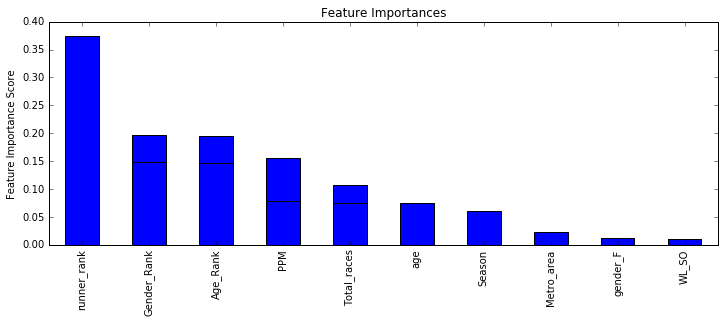

In [1073]:
models = [model2, model3]

modelfit(model2, X_train, y_train, X_test, y_test)
modelfit(model3, X_train, y_train, X_test, y_test)

In [1077]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GBC(learning_rate=0.1, min_samples_split=50,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=50, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [1155]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GBC(learning_rate=0.1, n_estimators=20, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_
psearch = gsearch2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, psearch[:,1])
print auc(fpr, tpr)

0.649840565938


In [1156]:
#modelfit(gsearch1, X_train, y_train, X_test, y_test)

In [1079]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.67064, std: 0.02891, params: {'n_estimators': 20},
  mean: 0.66522, std: 0.03129, params: {'n_estimators': 30},
  mean: 0.66365, std: 0.03181, params: {'n_estimators': 40},
  mean: 0.66117, std: 0.03330, params: {'n_estimators': 50},
  mean: 0.65608, std: 0.03523, params: {'n_estimators': 60},
  mean: 0.66043, std: 0.03306, params: {'n_estimators': 70},
  mean: 0.66434, std: 0.03163, params: {'n_estimators': 80}],
 {'n_estimators': 20},
 0.6706365364910878)

In [1093]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GBC(learning_rate=0.1, n_estimators=20,max_depth=5,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.67949, std: 0.02647, params: {'min_samples_split': 1000, 'min_samples_leaf': 30},
  mean: 0.68234, std: 0.02162, params: {'min_samples_split': 1200, 'min_samples_leaf': 30},
  mean: 0.67251, std: 0.02539, params: {'min_samples_split': 1400, 'min_samples_leaf': 30},
  mean: 0.66786, std: 0.02394, params: {'min_samples_split': 1600, 'min_samples_leaf': 30},
  mean: 0.67317, std: 0.02511, params: {'min_samples_split': 1800, 'min_samples_leaf': 30},
  mean: 0.67498, std: 0.02223, params: {'min_samples_split': 2000, 'min_samples_leaf': 30},
  mean: 0.67854, std: 0.02783, params: {'min_samples_split': 1000, 'min_samples_leaf': 40},
  mean: 0.68438, std: 0.02359, params: {'min_samples_split': 1200, 'min_samples_leaf': 40},
  mean: 0.67213, std: 0.02466, params: {'min_samples_split': 1400, 'min_samples_leaf': 40},
  mean: 0.66776, std: 0.02422, params: {'min_samples_split': 1600, 'min_samples_leaf': 40},
  mean: 0.67471, std: 0.02442, params: {'min_samples_split': 1800, 'min_samples_


Model Report: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=40,
              min_samples_split=1200, min_weight_fraction_leaf=0.0,
              n_estimators=20, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False)
Accuracy : 0.9523
AUC Score (Train): 0.644234
CV Score : Mean - 0.6843817 | Std - 0.02358628 | Min - 0.6515409 | Max - 0.7114398


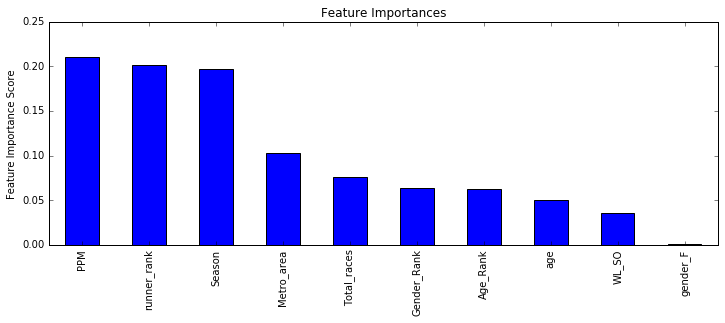

In [1115]:
modelfit(gsearch3.best_estimator_, X_train, y_train, X_test, y_test)

In [1119]:
param_test4 = {'max_features':range(1,10,1)}
gsearch4 = GridSearchCV(estimator = GBC(learning_rate=0.1, n_estimators=20,max_depth=5, min_samples_split=50, min_samples_leaf=5, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.65159, std: 0.02653, params: {'max_features': 1},
  mean: 0.67288, std: 0.02768, params: {'max_features': 2},
  mean: 0.67171, std: 0.02604, params: {'max_features': 3},
  mean: 0.67884, std: 0.02182, params: {'max_features': 4},
  mean: 0.67550, std: 0.01269, params: {'max_features': 5},
  mean: 0.68055, std: 0.02184, params: {'max_features': 6},
  mean: 0.67915, std: 0.02438, params: {'max_features': 7},
  mean: 0.67826, std: 0.02419, params: {'max_features': 8},
  mean: 0.67518, std: 0.01990, params: {'max_features': 9}],
 {'max_features': 6},
 0.680550543103162)